Ссылка на датасет https://www.kaggle.com/datasets/primaryobjects/voicegender?resource=download

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# По примеру 2

Читаем датасет

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/datasets/voice.csv')


In [ ]:
df.head(10)

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male
5,0.132786,0.079557,0.119090,0.067958,0.209592,0.141634,1.932562,8.308895,0.963181,0.738307,...,0.132786,0.110132,0.017112,0.253968,0.298222,0.007812,2.726562,2.718750,0.125160,male
6,0.150762,0.074463,0.160106,0.092899,0.205718,0.112819,1.530643,5.987498,0.967573,0.762638,...,0.150762,0.105945,0.026230,0.266667,0.479620,0.007812,5.312500,5.304688,0.123992,male
7,0.160514,0.076767,0.144337,0.110532,0.231962,0.121430,1.397156,4.766611,0.959255,0.719858,...,0.160514,0.093052,0.017758,0.144144,0.301339,0.007812,0.539062,0.531250,0.283937,male
8,0.142239,0.078018,0.138587,0.088206,0.208587,0.120381,1.099746,4.070284,0.970723,0.770992,...,0.142239,0.096729,0.017957,0.250000,0.336476,0.007812,2.164062,2.156250,0.148272,male
9,0.134329,0.080350,0.121451,0.075580,0.201957,0.126377,1.190368,4.787310,0.975246,0.804505,...,0.134329,0.105881,0.019300,0.262295,0.340365,0.015625,4.695312,4.679688,0.089920,male


Функция для определения является ли признак категориальным или числовым

In [ ]:
def utils_recognize_type(df, col, max_cat=20):
    if (df[col].dtype == "O") | (df[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

Создание словаря, где ключ - это название признака, а значение - категориальный или числовой

In [ ]:
dic_cols = {col:utils_recognize_type(df, col, max_cat=20) for col in df.columns}

Преобразование исходного датасета, где вместо значений True или False в зависимости от присутствия там значения

In [ ]:
heatmap = df.isnull()

Меняем значения в полученном датасете на
*   0, если признак категориальный и значение не нулевое,
*   0.5, если признак числовой и значение не нулевое,
*   1, если значение нулевое вне зависимости от признака





In [ ]:
for k,v in dic_cols.items():
    if v == "num":
        heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
    else:
        heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)

Отрисовываем тепловую карту по полученному датасету

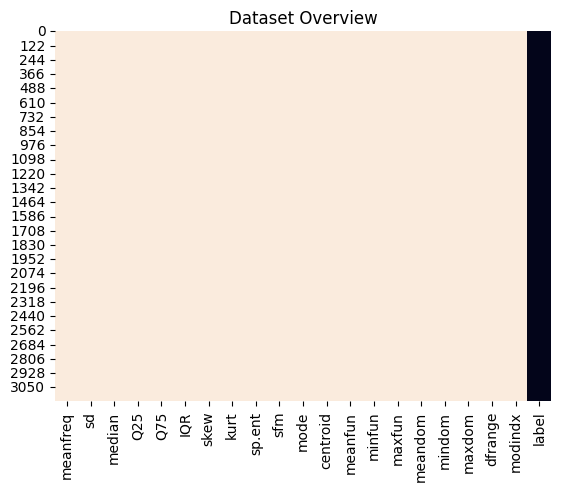

 Categerocial   Numeric   Nan 


In [ ]:
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')

plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;47m Numeric ", "\033[1;30;41m Nan ")

Вывод: пропущенных значений нет, только label является категориальным признаком

Анализ количества записей для двух групп

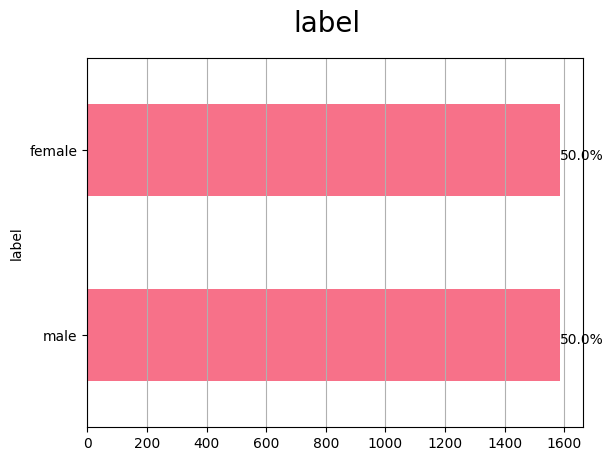

In [ ]:
y ="label" # выбираем столбец, по которому группироуем

# подсчёт количества элементов в каждой группе
ax = df[y].value_counts().sort_values().plot(kind="barh")
totals= []

# надписи для графика
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.20,
            str(round((i.get_width()/total)*100, 2))+'%',
            fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(y, fontsize=20)
plt.show()

Совпадает с тем, что было в первой части блокнота - распределение записей поровну

Функция для визуализации распределения данных в каком-то столбце

In [ ]:
def show_dist(x, df):
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15, 10))
    fig.suptitle(x, fontsize=20)
    ### distribution
    ax[0].title.set_text('distribution')
    variable = df[x].fillna(df[x].mean())
    breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
    variable = variable[(variable > breaks[0]) & (variable <
                                                  breaks[10])]
    sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
                 ax=ax[0])  #Запишем чтобы создать горизонтальную гистограмму
    des = df[x].describe()

    ax[0].axvline(des["25%"], ls='--')
    ax[0].axvline(des["mean"], ls='--')
    ax[0].axvline(des["75%"], ls='--')
    ax[0].grid(True)
    des = round(des, 2).apply(lambda x: str(x))
    box = '\n'.join(
        ("min: " + des["min"], "25%: " + des["25%"], "mean: " + des["mean"], "75%: " + des["75%"], "max: " + des["max"]))
    ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right",
               bbox=dict(boxstyle='round', facecolor='white', alpha=1))

    ### boxplot
    ax[1].title.set_text('outliers (log scale)')  #устанавливаем заголовок
    tmp_df = pd.DataFrame(df[x])
    tmp_df[x] = np.log1p(tmp_df[x])
    tmp_df.boxplot(column=x, ax=ax[1])

    plt.show()

<ipython-input-29-8a772d0bc045>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


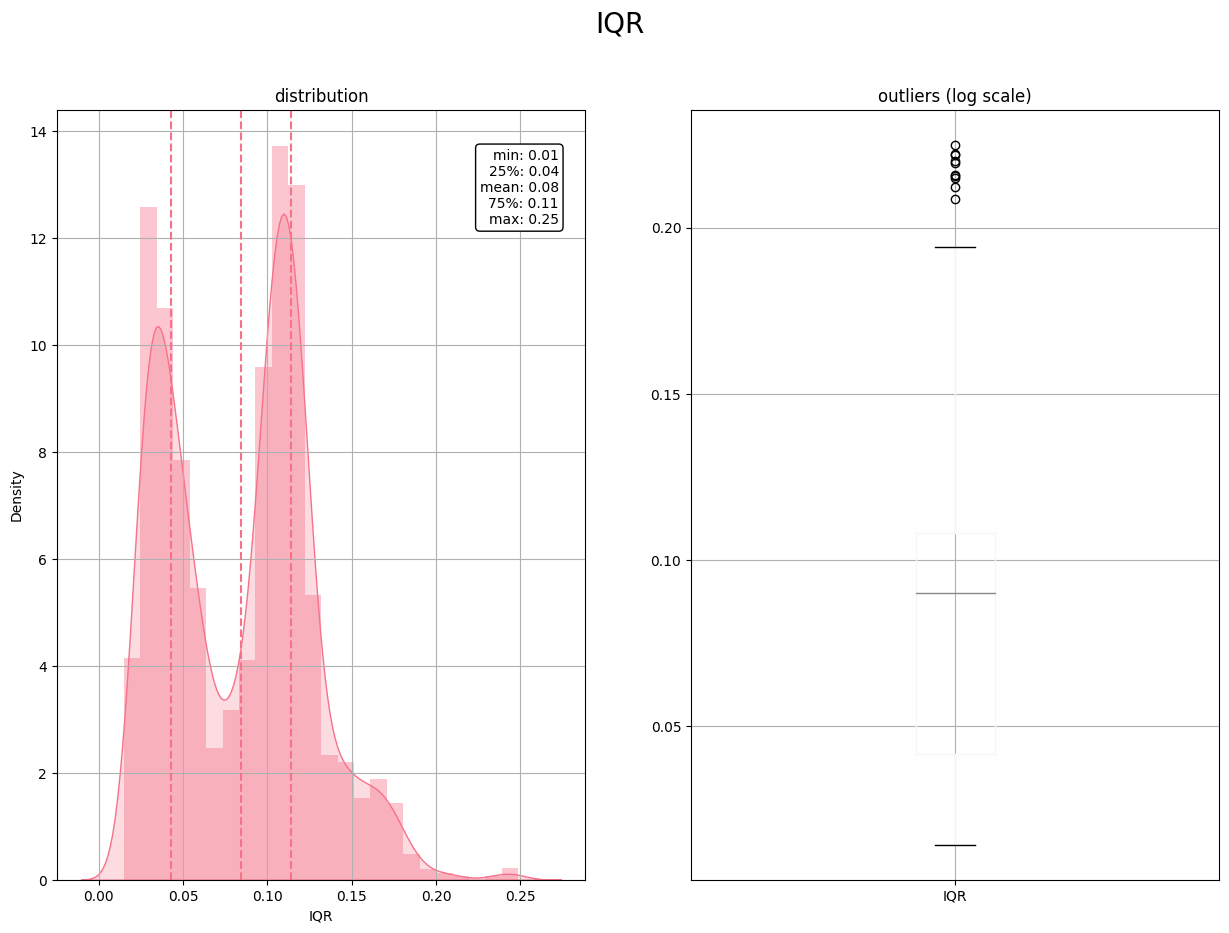

In [ ]:
show_dist('IQR', df)

Графики для понимания, обладает ли IQR предсказательной силой

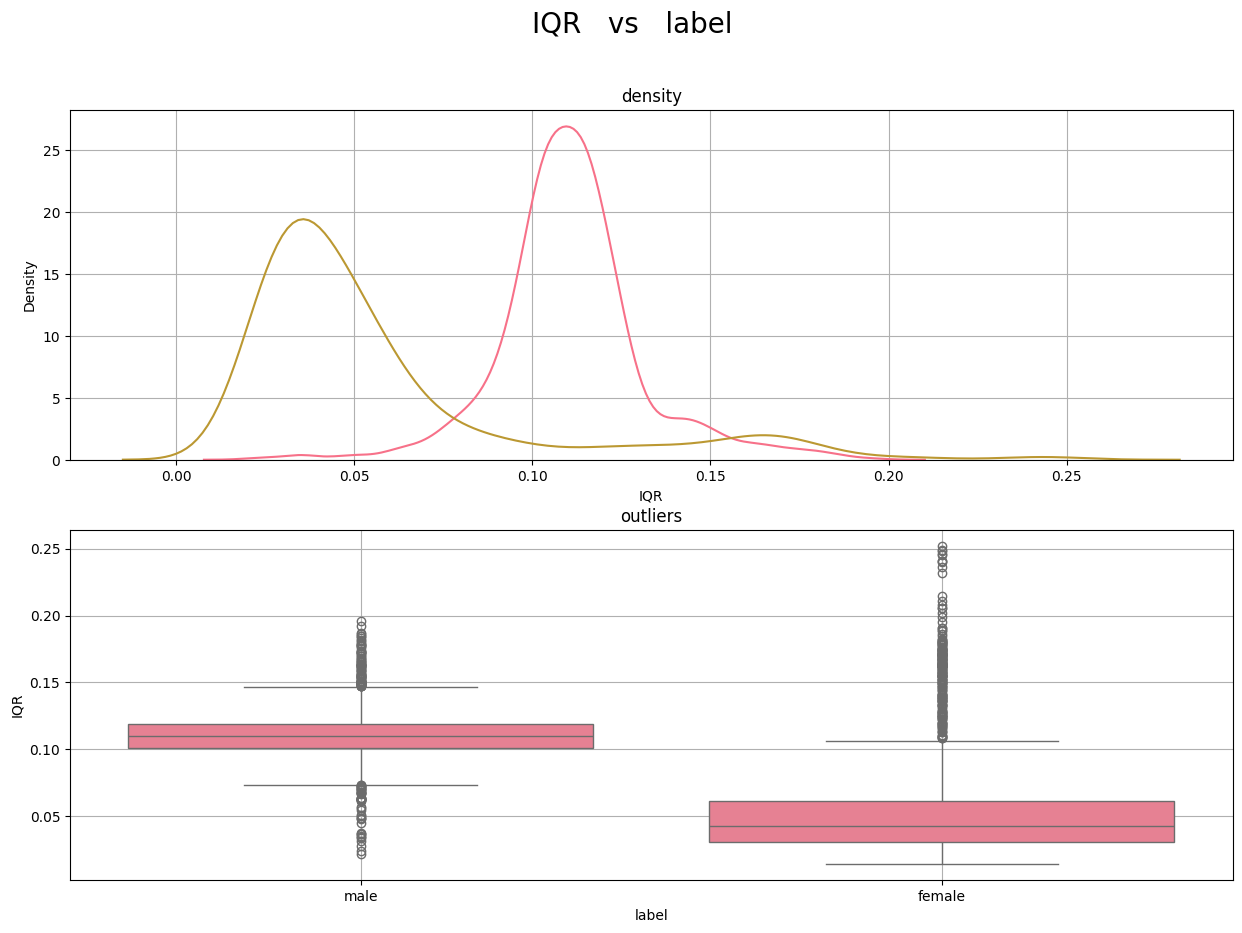

In [ ]:
x = 'IQR'
cat, num = "label", "IQR"
fig, ax = plt.subplots(nrows=2, ncols=1,  sharex=False, sharey=False, figsize=(15, 10))# распаковываем  кортеж в переменные figи ax.
fig.suptitle(x+"   vs   "+y, fontsize=20)# получаем объект рисунка и массив подграфиков,где первое число - количество строк,второе - столбцов, sharex, sharey задают нужно ли разделять ось между подграфиками

### distribution
ax[0].title.set_text('density')
for i in df[cat].unique():  # перебираем все уникальные значения в столбце dtf[cat], cat="species"
    sns.kdeplot(df[df[cat]==i][num],   label=i, ax=ax[0])#Построим график плотности распределения в столбце num, при условии, что значение в столбце dtf[cat] совпадет с i
ax[0].grid(True)#Настроим линии сетки.

### boxplot
ax[1].title.set_text('outliers')#устанавливаем заголовок
sns.boxplot(x=cat, y=num, data=df, ax=ax[1])#Нарисуем блочную диаграмму, чтобы показать распределения по категориям.


ax[1].grid(True)#Настроим линии сетки.
'''
  Отрисовываем
'''

plt.show()

Функция для подготовки датасета

In [ ]:

def prep(df):

    df.loc[df.label == 'male', 'gender'] = 1
    df.loc[df.label == 'female', 'gender'] = 0

    emdf = df.dropna(axis=0, how='any', inplace=False)#Удалм пропущенные значения
    return  emdf


In [ ]:
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

Разделение на тестовый и обучающий наборы

In [ ]:
## split data , 70% - тренировочная выборка, 30% тестовая выборка
df_tr, df_t = model_selection.train_test_split(df, test_size=0.3)

# подготавливаем данные в трейне и тесте одинаково
df_train = prep(df_tr)
df_test = prep(df_t)

## print info
print("X_train shape:", df_train.drop("label",axis=1).shape, "| X_test shape:", df_test.drop("label",axis=1).shape)
print("y_train mean:", round(np.mean(df_train["gender"]),2), "| y_test mean:", round(np.mean(df_test["gender"]),2))
print(df_train.drop("label",axis=1).shape[1], "features:", df_train.drop("gender",axis=1).columns.to_list())

X_train shape: (2217, 21) | X_test shape: (951, 21)
y_train mean: 0.5 | y_test mean: 0.49
21 features: ['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt', 'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun', 'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'label']


In [ ]:
df_train.shape

(2217, 22)

In [ ]:
# формируем вспомогательный датасет (где все нужные фичи(столбцы), и нет целевой переменной) и series с целевой переменной. Для трейна
train_x = df_train[['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt', 'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun', 'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx' ]]
train_y = df_train['gender']

In [ ]:
# формируем вспомогательный датасет (где все нужные фичи(столбцы), и нет целевой переменной) и series с целевой переменной. Для теста

test_x = df_test[['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt', 'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun', 'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx' ]]
test_y = df_test['gender']

In [ ]:

# нормируем значения
Y = 'gender'

scaler = preprocessing.MinMaxScaler(feature_range=(0,1))#приведем Числовые переменные (Numeric Variable) к диапазону от 0 до 1.
X = scaler.fit_transform(train_x)#преобразуем данные таким образом, что их распределение будет иметь среднее значение 0 и стандартное отклонение 1.

train_x_scaled = pd.DataFrame(X, columns=train_x.columns,index=train_x.index )
train_y_scaled = train_y

train_x_scaled.head()# выводим



,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
1816,0.655241,0.089581,0.666244,0.679512,0.623896,0.041330,0.080900,0.008446,0.312726,0.133969,0.605027,0.655241,0.640900,0.361413,0.659496,0.070320,0.340659,0.041458,0.034692,0.101093
2202,0.773531,0.172624,0.782875,0.744999,0.755668,0.092557,0.067914,0.006722,0.478823,0.215526,0.770833,0.773531,0.513279,0.196972,0.999749,0.223717,0.041758,0.240886,0.240343,0.050885
1548,0.539388,0.431655,0.469858,0.456225,0.778422,0.413409,0.080413,0.009829,0.699367,0.473778,0.413913,0.539388,0.315996,0.151516,0.705483,0.119968,0.000000,0.035606,0.035765,0.568505
1302,0.651868,0.387199,0.737830,0.472462,0.774135,0.392645,0.043149,0.003580,0.648440,0.370310,0.698630,0.651868,0.342729,0.197219,0.990585,0.210448,0.041758,0.218370,0.217811,0.110151
0,0.056819,0.454152,0.084125,0.060038,0.148350,0.254828,0.365223,0.208279,0.621941,0.539768,0.000000,0.056819,0.131960,0.030501,0.981526,0.000000,0.006593,0.000000,0.000000,0.000000


In [ ]:
X

array([[0.6552407 , 0.08958107, 0.66624358, ..., 0.04145818, 0.03469242,
        0.10109275],
       [0.77353065, 0.17262371, 0.78287465, ..., 0.24088635, 0.24034335,
        0.05088513],
       [0.53938792, 0.43165491, 0.46985809, ..., 0.03560579, 0.03576538,
        0.5685052 ],
       ...,
       [0.74464774, 0.32855715, 0.69225179, ..., 0.24410293, 0.24427754,
        0.16742063],
       [0.43079801, 0.69129823, 0.46252914, ..., 0.19621158, 0.19635193,
        0.39604965],
       [0.65990568, 0.39026822, 0.60122314, ..., 0.33952823, 0.33905579,
        0.14734756]])

In [ ]:
train_x.index


Index([1816, 2202, 1548, 1302,    0, 3137,  180,  770, 2182,  922,
       ...
       1223,  118, 1462, 2658,  447,  864, 2829,  299,   58, 1283],
      dtype='int64', length=2217)

In [ ]:
X = scaler.fit_transform(test_x)

test_x_scaled = pd.DataFrame(X, columns=test_x.columns,index=test_x.index )
test_y_scaled = test_y

In [ ]:
df

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,0.131884,0.084734,0.153707,0.049285,0.201144,0.151859,1.762129,6.630383,0.962934,0.763182,...,0.131884,0.182790,0.083770,0.262295,0.832899,0.007812,4.210938,4.203125,0.161929,female
3164,0.116221,0.089221,0.076758,0.042718,0.204911,0.162193,0.693730,2.503954,0.960716,0.709570,...,0.116221,0.188980,0.034409,0.275862,0.909856,0.039062,3.679688,3.640625,0.277897,female
3165,0.142056,0.095798,0.183731,0.033424,0.224360,0.190936,1.876502,6.604509,0.946854,0.654196,...,0.142056,0.209918,0.039506,0.275862,0.494271,0.007812,2.937500,2.929688,0.194759,female
3166,0.143659,0.090628,0.184976,0.043508,0.219943,0.176435,1.591065,5.388298,0.950436,0.675470,...,0.143659,0.172375,0.034483,0.250000,0.791360,0.007812,3.593750,3.585938,0.311002,female


Матрица корреляции

Text(0.5, 1.0, 'pearson correlation')

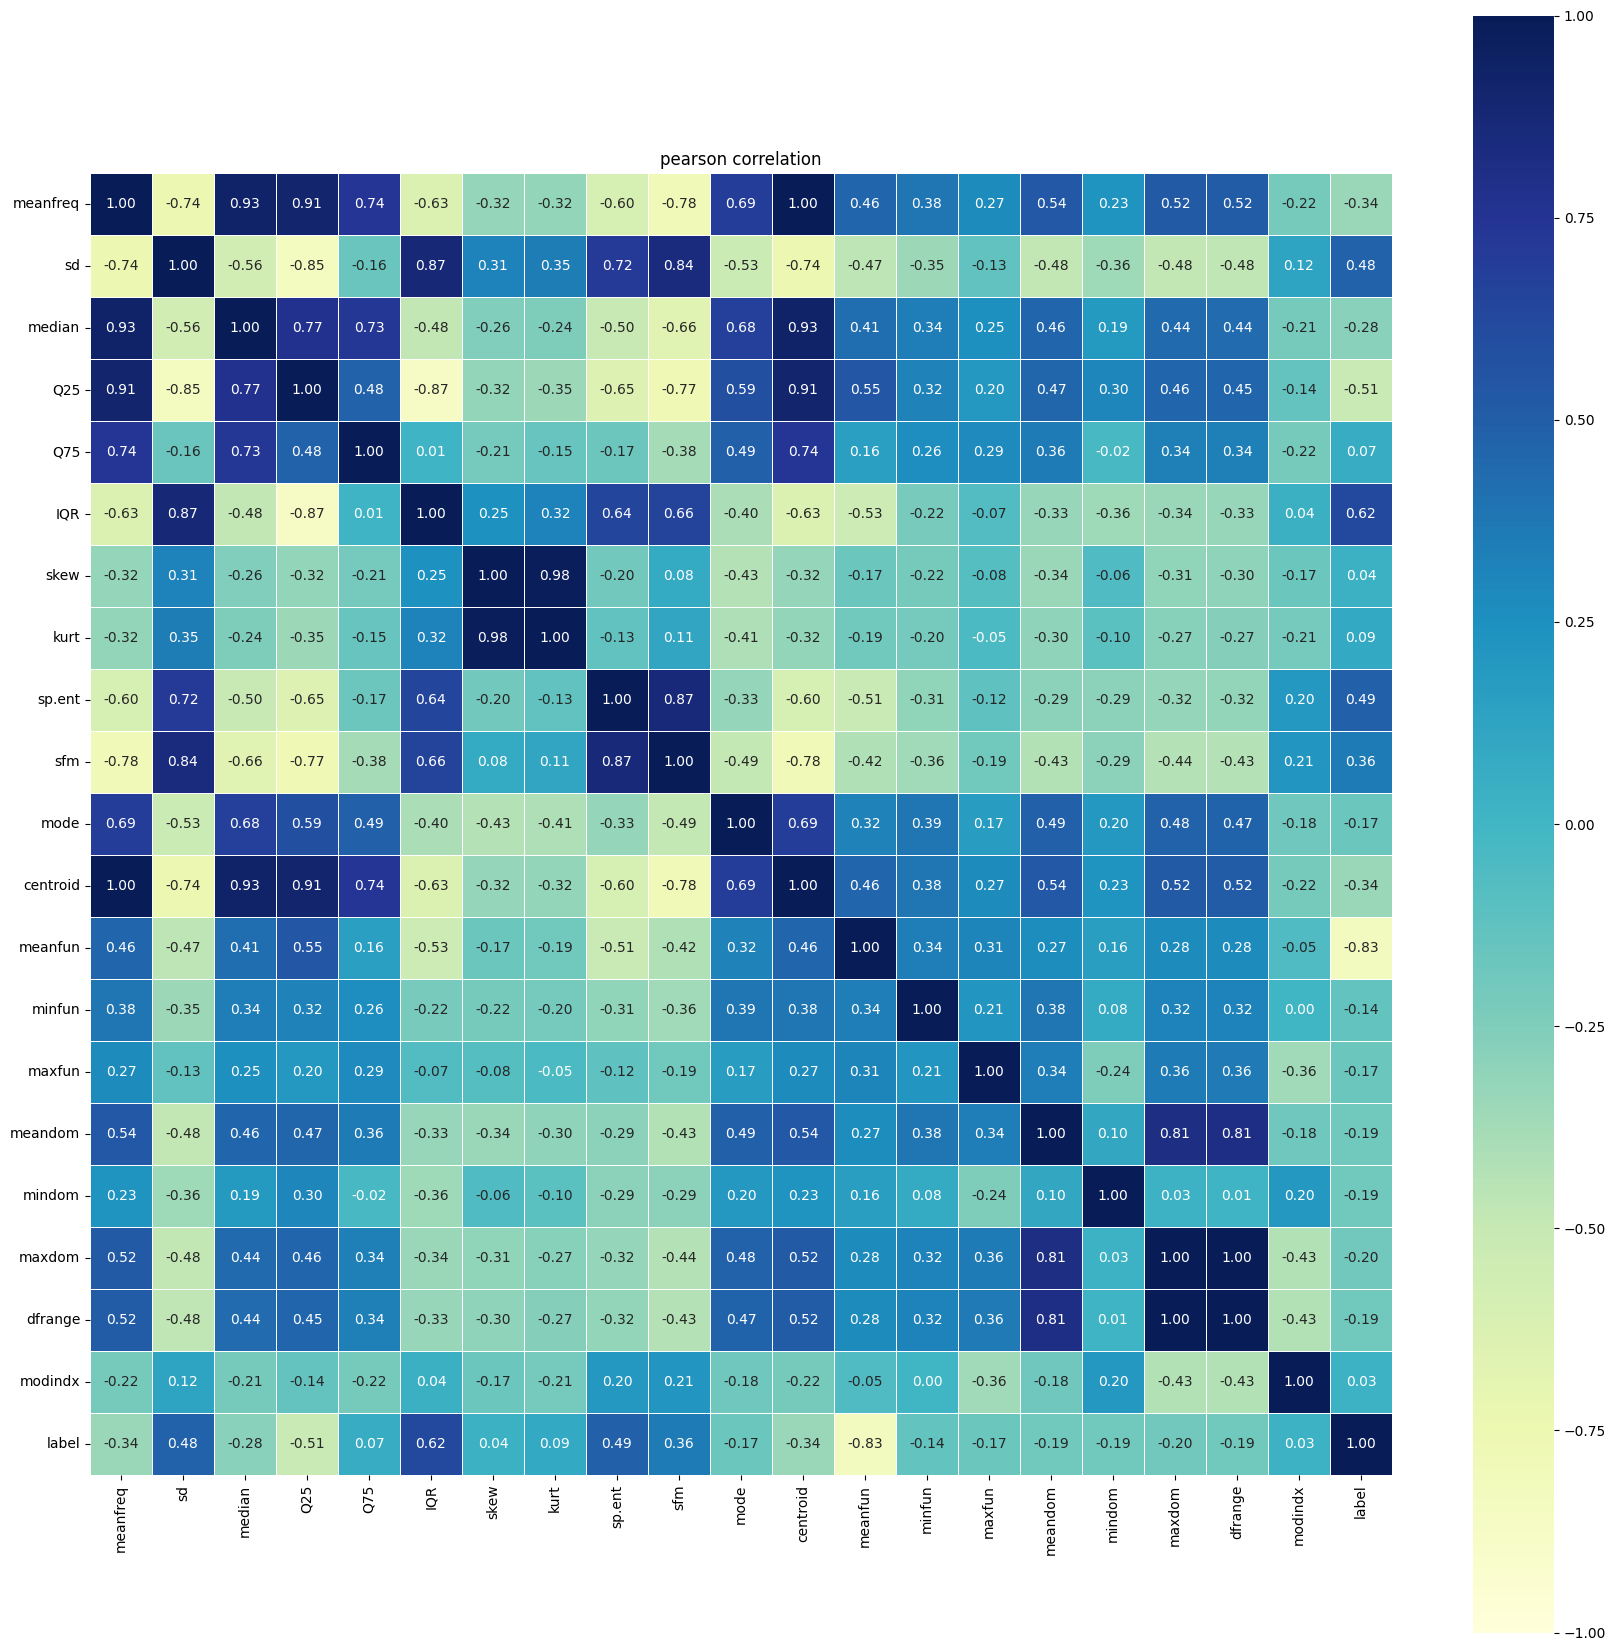

In [ ]:
corr_matrix = df.copy()
plt.figure(figsize=(21,21),dpi=100)

for col in corr_matrix.columns: #зададим условия для столбцов
  if corr_matrix[col].dtype == "O":
          corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
corr_matrix = corr_matrix.corr(method="pearson",numeric_only = True)

sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5, square=True)
plt.title("pearson correlation")

Оценка важности каждого признака

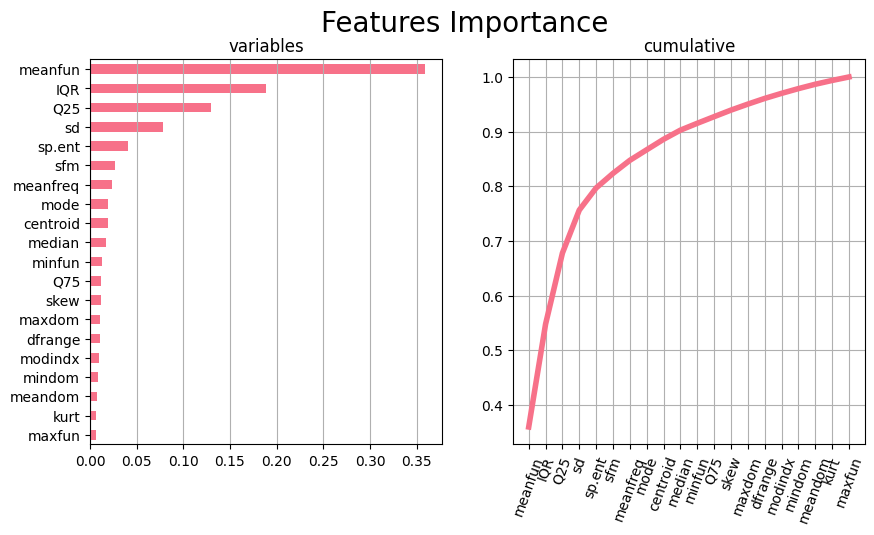

In [ ]:

X = train_x_scaled.values
y = train_y_scaled.values
feature_names = train_x_scaled.columns.tolist()# имена столбцов в data.
## Importance
model = ensemble.RandomForestClassifier(n_estimators=100,
                                        criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_ #это оценка, присваиваемая функциям модели машинного обучения,которая определяет, насколько «важной» является функция для прогноза модели.
## Put in a pandas dtf
df_importances = pd.DataFrame({"IMPORTANCE":importances,
                                "VARIABLE":feature_names}).sort_values("IMPORTANCE",
                                                                       ascending=False)
df_importances['cumsum'] = df_importances['IMPORTANCE'].cumsum(axis=0)
df_importances = df_importances.set_index("VARIABLE")


## Plot

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False,figsize=(10,5),dpi=100)# распаковываем  кортеж в переменные figи ax.
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')# подпишем график
df_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
    kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')# подпишем график
df_importances[["cumsum"]].plot(kind="line", linewidth=4,
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(df_importances)),
          xticklabels=df_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')#Настроим линии сетки.

plt.show()

Возьмём первые 4 по важности признака

In [ ]:
X_train = train_x_scaled[['meanfun','IQR','Q25','sd']]
y_train = train_y_scaled

X_test = test_x_scaled[['meanfun','IQR','Q25','sd']]
y_test = test_y_scaled

Градиентный бустинг

In [ ]:
model = ensemble.GradientBoostingClassifier()

param_dic = {'learning_rate':[0.15,0.1,0.05],     #весовой коэффициент для поправок по новым деревьям при добавлении в модель
             'n_estimators':[100,250,500],  #количество деревьев, добавленных в модель
             'max_depth':[2,3,4,5],    #максимальная глубина дерева
             'min_samples_split':[2,4,6],    #задает минимальное количество выборок для разделения
             'min_samples_leaf':[1,3,5],     #минимальное количество выборок для формирования листа
             'max_features':[2,3,4],     #квадратный корень из функций обычно является хорошей отправной точкой
             'subsample':[0.7,0.8,0.9,1]}       #образцы, которые будут использоваться для подгонки индивидуального базового файла

random_search = model_selection.RandomizedSearchCV(model,
                                                   param_distributions=param_dic, n_iter=10,
                                                   scoring="accuracy").fit(X_train, y_train)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
model = random_search.best_estimator_

Best Model parameters: {'subsample': 0.7, 'n_estimators': 250, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 3, 'max_depth': 5, 'learning_rate': 0.05}
Best Model mean accuracy: 0.974743253411425


In [ ]:
model.fit(X_train, y_train)

predicted_prob = model.predict_proba(X_test) #прогнозирование

predicted = model.predict(X_test).astype('int32')

In [ ]:
predicted_prob

array([[9.99498810e-01, 5.01190308e-04],
       [5.74058227e-04, 9.99425942e-01],
       [9.99074408e-01, 9.25591828e-04],
       ...,
       [9.99339343e-01, 6.60656719e-04],
       [3.03454083e-04, 9.99696546e-01],
       [6.50650670e-03, 9.93493493e-01]])

In [ ]:
y_test.astype('int32')

,gender
2920,0
312,1
1635,0
1024,1
347,1
...,...
2824,0
677,1
2598,0
1487,1


Метрики

In [ ]:
y_test

,gender
2920,0.0
312,1.0
1635,0.0
1024,1.0
347,1.0
...,...
2824,0.0
677,1.0
2598,0.0
1487,1.0


In [ ]:
accuracy = metrics.accuracy_score(y_test, predicted)#Оценим точность классификации.

predicted_prob = model.predict_proba(X_test)[:, 1] # так как классификация бинарная, нужно выбрать вероятности только для одного класса

auc = metrics.roc_auc_score(y_test, predicted_prob,  multi_class='ovo',average= "weighted") #возвращаем долю правильно классифицированных выборок.
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))


recall = metrics.recall_score(y_test, predicted, average="weighted")
precision = metrics.precision_score(y_test, predicted, average="weighted")
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in np.unique(y_test)]))

Accuracy (overall correct predictions): 0.98
Auc: 1.0
Recall (all 1s predicted right): 0.98
Precision (confidence when predicting a 1): 0.98
Detail:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       486
         1.0       0.99      0.96      0.97       465

    accuracy                           0.98       951
   macro avg       0.98      0.98      0.98       951
weighted avg       0.98      0.98      0.98       951



ROC-кривые

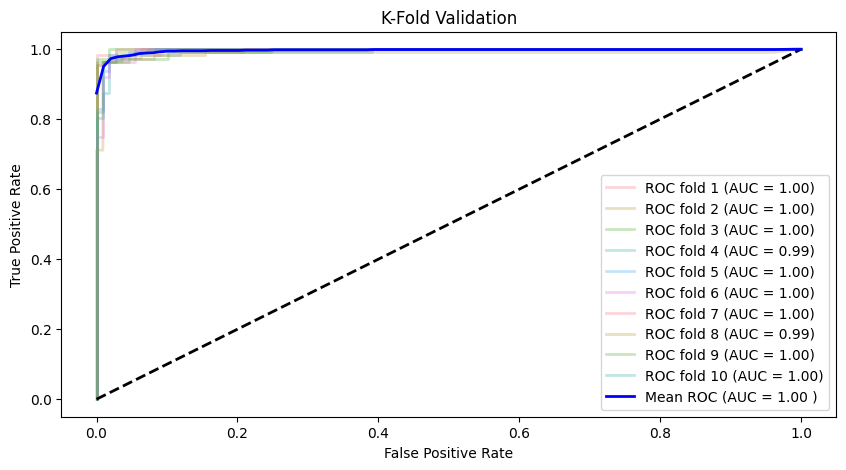

In [ ]:

cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure(figsize=(10,5),dpi=100)
i = 1
for train, test in cv.split(X_train, y_train):
    X_train_selected = X_train.iloc[train]

    y_train_selected = y_train.iloc[train]
    X_train_selected_test = X_train.iloc[test]
    y_train_selected_test = y_train.iloc[test]

    prediction = model.fit(X_train_selected, y_train_selected).predict_proba(X_train_selected_test)
    fpr, tpr, t = metrics.roc_curve(y_train_selected_test, prediction[:, 1], pos_label=1)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i = i+1

plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")

plt.show()

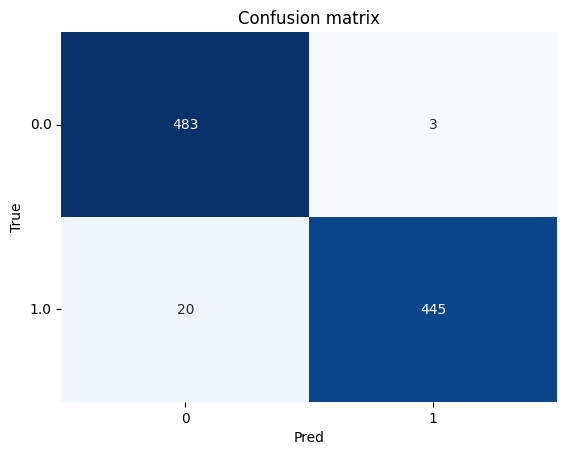

In [ ]:
classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)

plt.show()

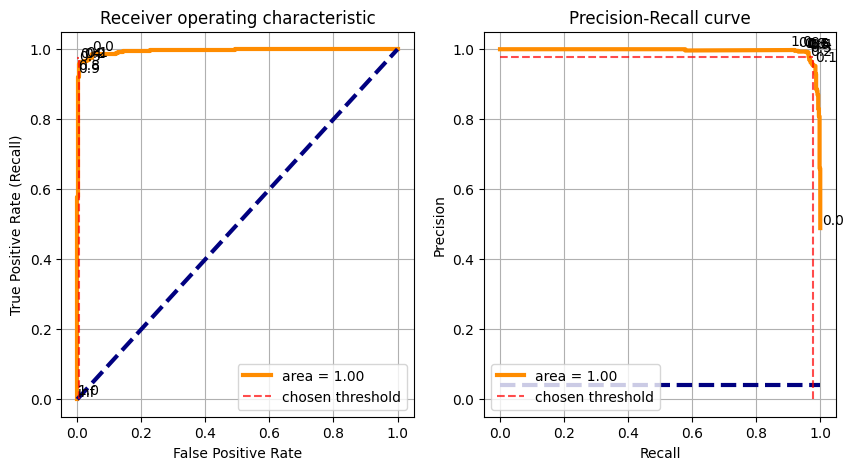

In [ ]:
classes = np.unique(y_test)
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5),dpi=100)

fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_prob, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
ax[0].plot(fpr, tpr, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].hlines(y=recall, xmin=0, xmax=1-cm[0,0]/(cm[0,0]+cm[0,1]), color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[0].vlines(x=1-cm[0,0]/(cm[0,0]+cm[0,1]), ymin=0, ymax=recall, color='red', linestyle='--', alpha=0.7)
ax[0].set(xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)


thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
        ax[0].annotate(t, xy=(fpr[i],tpr[i]), xytext=(fpr[i],tpr[i]),
                    textcoords='offset points', ha='left', va='bottom')
        thres_in_plot.append(t)
    else:
        next


precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, predicted_prob, pos_label=1)
roc_auc = metrics.auc(recalls, precisions)
ax[1].plot(recalls, precisions, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[1].plot([0,1], [(cm[1,0]+cm[1,0])/len(y_test), (cm[1,0]+cm[1,0])/len(y_test)], linestyle='--', color='navy', lw=3)
ax[1].hlines(y=precision, xmin=0, xmax=recall, color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[1].vlines(x=recall, ymin=0, ymax=precision, color='red', linestyle='--', alpha=0.7)
ax[1].set(xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="lower left")
ax[1].grid(True)

thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
        ax[1].annotate(np.round(t,1), xy=(recalls[i],precisions[i]),
                    xytext=(recalls[i],precisions[i]),
                    textcoords='offset points', ha='left', va='bottom')
        thres_in_plot.append(t)
    else:
        next
plt.show()

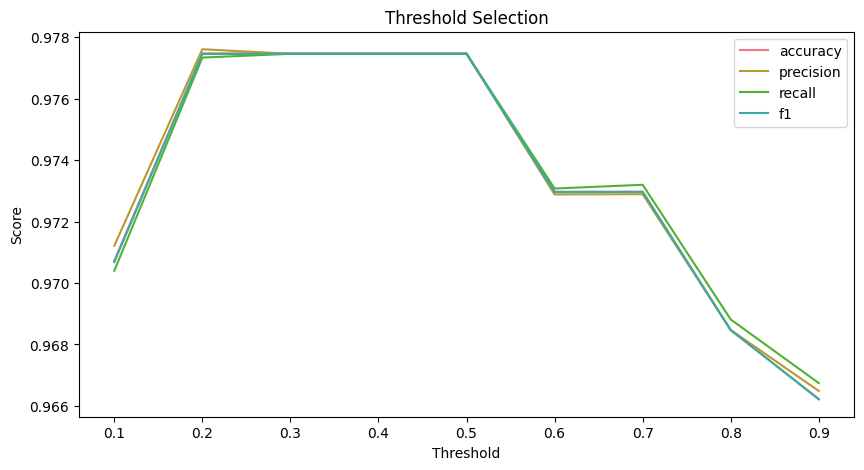

In [ ]:

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5),dpi=100)

dic_scores = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}
XX_train, XX_test, yy_train, yy_test = model_selection.train_test_split(X_train, y_train, test_size=0.2)
predicted_prob = model.fit(XX_train, yy_train).predict_proba(XX_test)[:,1]
thresholds = []
for threshold in np.arange(0.1, 1, step=0.1):
    predicted = (predicted_prob > threshold)
    thresholds.append(threshold)
    dic_scores["accuracy"].append(metrics.accuracy_score(yy_test, predicted))
    dic_scores["precision"].append(metrics.precision_score(yy_test, predicted, average='macro', zero_division=1))
    dic_scores["recall"].append(metrics.recall_score(yy_test, predicted, average='macro'))
    dic_scores["f1"].append(metrics.f1_score(yy_test, predicted, average='macro'))

dtf_scores = pd.DataFrame(dic_scores).set_index(pd.Index(thresholds))
ax.set(xlabel='Threshold', ylabel="Score", title="Threshold Selection")
dtf_scores.plot(ax=ax)


plt.show()